This notebook shows a sequential design example in `hetGPy`. It combines several aspects of previous examples, such as acquisition functions like **Expected Improvement (EI)** or **Integreated Mean-Squared Prediction Error (IMPSE)**.

Note that these examples represent advanced use of the package.

### Sequential Design for Expected Improvement

Consider the following example from Figure 10 of [Jones, Schonlau, and Welch (1998)](https://link.springer.com/article/10.1023/A:1008306431147) and from [(Schonlau 1997)](https://uwspace.uwaterloo.ca/handle/10012/190). The code and narrative text for this example were adpated from chapter 7.2 of [Gramacy (2020)](https://bookdown.org/rbg/surrogates/chap7.html#chap7ei).

Note the large gap along the x-axis before the final input. This leads to a large prediction interval between those inputs. We can calculate the EI along a dense grid of inputs and notice the tradeoff between "exploration" (choosing a design in the high noise region) and "exploitation" (choosing a design near the current observed globabl minimum).

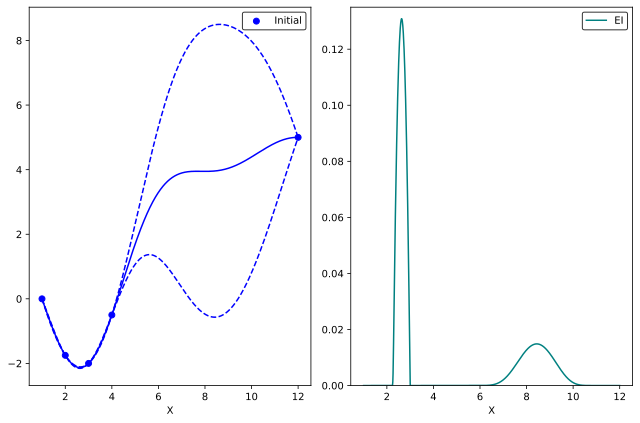

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np
from hetgpy import homGP
from hetgpy.optim import crit_EI
from scipy.stats import norm
import matplotlib.pyplot as plt
X = np.array([1, 2, 3, 4, 12]).reshape(-1,1)
Y = np.array([0, -1.75, -2, -0.5, 5])

model = homGP()
model.mle(X=X,
      Z=Y,
      covtype='Gaussian',
      init={'theta':np.array([10.0]),'g':1e-8}
)
Xgrid = np.linspace(1,12,1000).reshape(-1,1)
preds = model.predict(x=Xgrid)
preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2'])).squeeze()
preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2'])).squeeze()

fig, ax = plt.subplots(ncols=2,figsize=(9,6),sharex=True)
ax[0].scatter(X,Y,color='blue',label='Initial')
ax[0].plot(Xgrid,preds['mean'],color='blue')
ax[0].plot(Xgrid,preds['upper'],linestyle='dashed',color='blue')
ax[0].plot(Xgrid,preds['lower'],linestyle='dashed',color='blue')

EI_grid = crit_EI(x=Xgrid,model=model)
ax[1].plot(Xgrid,EI_grid,color='teal',label='EI')
ax[1].set_ylim([0,0.135])

ax[0].legend(edgecolor='black');ax[1].legend(edgecolor='black');
ax[0].set_xlabel('X');ax[1].set_xlabel('X');
fig.tight_layout()


We can then acquire a new design at the maximum EI location and update our model:


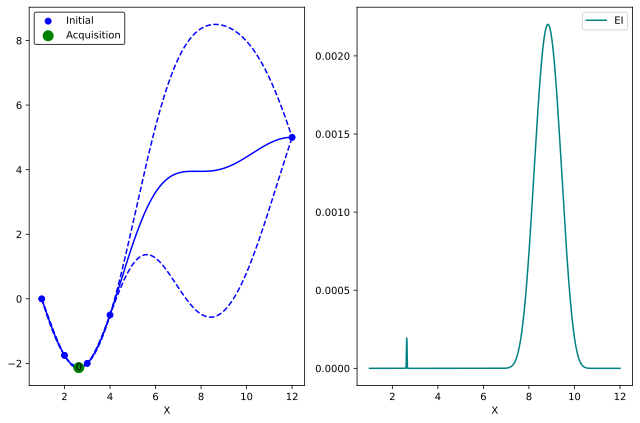

In [2]:
EI_grid = crit_EI(x=Xgrid,model=model)
design  = Xgrid[EI_grid.argmax()]
Xnew    = design.reshape(-1,1)
Znew    = model.predict(Xnew)['mean']
model.update(Xnew=Xnew,Znew=Znew)

ax[0].scatter(Xnew,Znew,label='Acquisition',s=100,color='green',zorder=2)
ax[0].text(Xnew,Znew,s='0',color='black',ha='center',va='center',zorder=3)
ax[0].legend(edgecolor='black');
EI_grid = crit_EI(x=Xgrid,model=model)
ax[1].clear()
ax[1].plot(Xgrid,EI_grid,color='teal',label='EI')
ax[1].legend()
ax[0].set_xlabel('X');ax[1].set_xlabel('X');
fig.tight_layout()
fig


And then we can acquire another update to capitalize on the "exploration" component (and reduce our uncertainty on the righthand side of the domain):

In [3]:
EI_grid = crit_EI(x=Xgrid,model=model)
design  = Xgrid[EI_grid.argmax()]
Xnew    = design.reshape(-1,1)
Znew    = model.predict(Xnew)['mean']
model.update(Xnew=Xnew,Znew=Znew)

preds = model.predict(x=Xgrid)
preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2'])).squeeze()
preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2'])).squeeze()

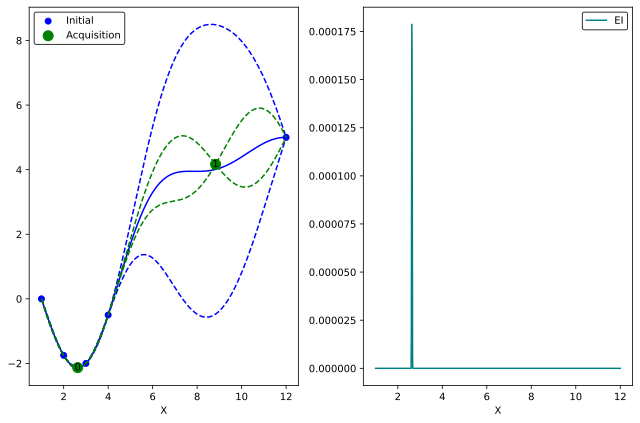

In [4]:
ax[0].scatter(Xnew,Znew,s=100,color='green',zorder=2)
ax[0].text(Xnew,Znew,s='1',color='black',ha='center',va='center',zorder=3)
ax[0].plot(Xgrid,preds['lower'],color='green',linestyle='dashed')
ax[0].plot(Xgrid,preds['upper'],color='green',linestyle='dashed')
ax[0].legend(edgecolor='black');
EI_grid = crit_EI(x=Xgrid,model=model)
ax[1].clear()
ax[1].plot(Xgrid,EI_grid,color='teal',label='EI')
ax[1].legend(edgecolor='black')
ax[0].set_xlabel('X');ax[1].set_xlabel('X');
fig.tight_layout()
fig

### Sequential Design for Integrated Mean-Squared Prediction Error


Instead of trying to find the global optimum of a function, a different goal is to efficiently learn the response surface, and thus pose the sequential design problem as one where we wish to minimize the (global) predictive variance.

Consider the function $f(x)=2(\exp(-30(x - 0.25)^2) + \sin(x^2)) - 2$ (implemented as `f1d2` in `hetGPy`) from [Boukouvalas and Cornford (2009)](https://scholar.google.com/scholar?q=Boukouvalas+A,+Cornford+D+(2009).+%E2%80%9CLearning+Heteroscedastic+Gaussian+Processes+for+Complex+Datasets.%E2%80%9D&hl=en&as_sdt=0&as_vis=1&oi=scholart). The code below adapts the example from [Binois et. al 2021](https://www.jstatsoft.org/article/view/v098i13), Figure 7.

We use a heteroskedastic noise function $f_n(x)=1/3\exp(\sin(2\pi x))$ so the overall data-generating process is: 
$$
\begin{align*}
Y \sim N(f(x),r(x))
\end{align*}
$$


Since choosing a design location that is either a replicate (and thus from a discrete set of inputs) or a new one (which is continuous), we are mixing discrete and continuous optimization. This poses an issue for choosing replicates (since up to floating point error, we are unlikely to choose _exactly_ the same design location) We also use a replication-biased lookahead heuristic (governed by the $h$ parameter in `IMSPE_optim`) from [Binois et. al 2019](https://arxiv.org/abs/1710.03206) that tends to prefer replication. Details can be found in that paper or in [Gramacy 2020 Ch. 10.3.2](https://bookdown.org/rbg/surrogates/chap10.html#chap10lookahead).


In [5]:
from hetgpy import hetGP
from hetgpy.IMSE import IMSPE_optim

rand = np.random.default_rng(13)
def f1d2(x): 
    return 2*(np.exp(-30*(x - 0.25)**2) + np.sin(x**2)) - 2
def fn(x): 
    return 1/3 * (np.exp(np.sin(2 * np.pi * x)))
def fr(x):
    x = x.squeeze().reshape(-1)
    return f1d2(x) + rand.normal(size = max(x.shape[0],1), scale = fn(x), loc = 0)

X = np.linspace(0, 1, 15).reshape(-1,1)
Y = fr(X).squeeze()
Xorig = X.copy()
mod = hetGP()
mod.mle(X = X, Z = Y, lower = np.array([0.0001]), upper = np.array([1.0]),known={},init={})
opt = IMSPE_optim(mod, h = 5)

The following code cell wraps the routine in a loop to acquire 500 samples sequentially. Every 50 iterations, we re-train on the entire set of data acquired thus far (to prevent the log-likelihood from getting stuck in local optima).

Note that this cell takes a few minutes to run (hence the progress bar).

In [6]:
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore") # ignore occasional RuntimeWarnings in ll optimization
for i in tqdm(range(500)):
    opt  = IMSPE_optim(mod, h = 5)
    X    = np.concatenate([X, opt['par']],axis=0)
    Ynew = fr(opt['par'])
    Y    = np.concatenate([Y,Ynew])
    mod.update(Xnew = opt['par'], Znew = Ynew, ginit = mod.g*1.01,maxit=100,known={})
    if (i + 1) % 50 == 0:
        mod2 = hetGP()
        X, Y = X.copy(), Y.copy()
        mod2.mle(X = X,
                 Z = Y, 
                 lower = np.array([0.0001]),
                 upper = np.array([1.0])
        )
        if mod2.ll > mod.ll:
            mod = mod2.copy()
grid = np.linspace(0,1,1000).reshape(-1,1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:16<00:00,  1.58it/s]


The resulting figure shows that we acquire many samples (and replicates) in the high noise region. We also see that we get a faithful estimate of the data-generating process (shown in red). Gray bars shown the original design locations (with no replicates)

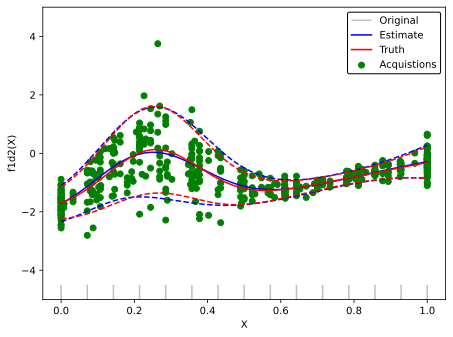

In [7]:
preds = mod.predict(grid)
preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2']+preds['nugs']).squeeze())
preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2']+preds['nugs']).squeeze())
fig, ax = plt.subplots()
ltrue = norm.ppf(0.05,loc=f1d2(grid),scale=fn(grid))
utrue = norm.ppf(0.95,loc=f1d2(grid),scale=fn(grid))
ax.vlines(Xorig,color='gray',ymin=-100,ymax=-4.5,label='Original',alpha=0.5)
# Estimate
ax.plot(grid,preds['mean'],label='Estimate',color='blue')
ax.plot(grid,preds['upper'],color='blue',linestyle='dashed')
ax.plot(grid,preds['lower'],color='blue',linestyle='dashed')
# Ground truth
ax.plot(grid,f1d2(grid),color='red',label='Truth')
ax.plot(grid,ltrue,color='red',linestyle='dashed')
ax.plot(grid,utrue,color='red',linestyle='dashed')

ax.scatter(X,Y,color='green',label='Acquistions')
ax.set_ylim(-5, 5)
ax.legend(edgecolor='black',facecolor='white',framealpha=1.0)
ax.set_xlabel('X');ax.set_ylabel('f1d2(X)')
fig.tight_layout()